In [5]:
elastic_rods_dir = '../../../../../elastic_rods/python/'
weaving_dir = '../../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, optimization_visualization_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
importlib.reload(optimization_visualization_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, highlight_rod_and_joint)
import vis.fields
import matplotlib.cm as cm
import time
from optimization_visualization_helper import (compute_visualization_data_from_raw_data, get_objective_components_stage1, get_objective_components_stage2, get_objective_components_stage3, set_figure_label_and_limit, Visualization_Setting, plot_objective, plot_ribbon_component_analysis)

In [6]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [7]:
rod_length = 0.3534025445286393
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
scale = 1
io = InputOrganizer('sphere_{}'.format(scale), thickness, width, weaving_dir)

0.11780084817621309 0.008246059372334916


In [8]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-8
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.1
dsw = 0.1

In [9]:
rw = 0.01
sw = 0.01

In [10]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view, linkage_color='lightgreen')
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [11]:
iterateData = stage_1_optimization(curved_linkage, rw, sw, curved_linkage_view)

In [12]:
# import pickle 
# import gzip
# pickle.dump(curved_linkage, gzip.open('sphere_test_20201202.pkl.gz', 'w'))

In [13]:
# curved_linkage = pickle.load(gzip.open('sphere_test_20201202.pkl.gz', 'r'))

In [14]:
curved_linkage.attraction_weight = 1e-5

In [15]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [16]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	0.000365261	0.00025534	0.00025534	1	0
1	0.000364895	0.000158828	0.000158828	1	0
2	0.000364892	1.34176e-07	1.34176e-07	1	0
3	0.000364892	1.26627e-10	1.26627e-10	1	0


In [22]:
import vis
from matplotlib import cm

stress = curved_linkage.maxBendingStresses()
new_stress = np.ones_like(stress) * np.max(stress)
new_stress[0] = stress[0]
new_stress[165] = stress[165]


#stress = curved_linkage.twistingStresses()
rangeMin = np.stack(stress).min()
rangeMax = np.stack(stress).max()
sf = vis.fields.ScalarField(curved_linkage, stress, colormap=cm.magma, vmin=rangeMin, vmax=rangeMax)

curved_linkage_view.showScalarField(sf)

In [19]:
curved_linkage.segment(0).startJoint

64

In [20]:
curved_linkage.joint(64).continuationSegment(0)

165

In [39]:
curved_linkage.energy()

0.00036489172907687054

In [ ]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw)

optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -5, 2)

In [13]:
curved_linkage.energy()

0.00036553992543518764

### Deactive crossing

In [36]:
import deactivate_crossing_helper
importlib.reload(deactivate_crossing_helper)
from deactivate_crossing_helper import (write_deactivated_linkage, copy_over_under, get_segment_index_from_joints, get_angle_from_kappa, get_kappa_from_angle, no_resample_deactivation, resample_deactivation)

In [37]:
deactive_index = 0
ju = curved_linkage.joint(deactive_index)
nbs = ju.neighbors()
deactive_model_name = ('/'.join(io.MODEL_PATH.split('/')[:-1] + [io.MODEL_NAME + '_deactive_joint_{}.obj'.format(deactive_index)]))
deactive_vertex_map = [i if i < deactive_index else i - 1 for i in range(curved_linkage.numJoints())]
write_deactivated_linkage(io, deactive_model_name, deactive_index, deactive_vertex_map, nbs)

In [38]:
with so(): deactivate_curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = deactive_model_name, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, interleaving_type=elastic_rods.InterleavingType.weaving)
deactivate_curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = deactivate_curved_linkage.jointPositions();
deactivate_curved_linkage_view = linkage_vis.LinkageViewer(deactivate_curved_linkage)
deactivate_curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [39]:
deactivate_curved_linkage_view.update()

In [40]:
copy_over_under(deactivate_curved_linkage, curved_linkage, deactive_vertex_map, deactive_index)
vf = show_selected_joints(deactivate_curved_linkage, [24, 0])
deactivate_curved_linkage_view.update(vectorField = vf)
deactivate_curved_linkage.setDoFs(deactivate_curved_linkage.getDoFs())
deactivate_design_parameter = deactivate_curved_linkage.getDesignParameters()
design_parameter = curved_linkage.getDesignParameters()
deactivate_rl_design_parameter_offset = deactivate_curved_linkage.numRestKappaVars()
rl_design_parameter_offset = curved_linkage.numRestKappaVars()

In [41]:
jpos = np.reshape(deactivate_curved_linkage.jointPositions(), (deactivate_curved_linkage.numJoints(), 3))


In [42]:
resample_deactivation(deactivate_curved_linkage, curved_linkage, deactive_vertex_map, nbs, deactive_index, io)

176
177


array([0.00804502, 0.00829447, 0.00852122, ..., 0.35196924, 0.70576309,
       0.70834909])

In [43]:
def eqm_callback(prob, i):
    deactivate_curved_linkage_view.update()

In [44]:
OPTS.niter = 10000

In [45]:
elastic_rods.compute_equilibrium(deactivate_curved_linkage, callback = eqm_callback, options = OPTS)

0	0.225276	30.3977	30.3977	1	1
1	0.0471569	2.22398	2.22398	1	1
2	0.0295794	0.837873	0.837873	1	1
3	0.0201293	0.456821	0.456821	1	1
4	0.0133929	0.292803	0.292803	1	1
5	0.00887039	0.160605	0.160605	1	1
6	0.00619252	0.0826812	0.0826812	1	1
7	0.00472454	0.0645807	0.0645807	1	1
8	0.00368492	0.0612067	0.0612067	1	1
9	0.00287668	0.0500332	0.0500332	1	1
10	0.00237518	0.0271004	0.0271004	1	1
11	0.00195067	0.0249181	0.0249181	1	1
12	0.00143747	0.0162134	0.0162134	1	1
13	0.000826782	0.0295532	0.0295532	0.5	0
14	0.000664243	0.0664544	0.0664544	1	0
15	0.000409378	0.0133112	0.0133112	0.5	0
16	0.000395916	0.00827871	0.00827871	1	0
17	0.000389315	0.00193828	0.00193828	1	0
18	0.000388328	0.000907984	0.000907984	1	0
19	0.000388248	4.84085e-05	4.84085e-05	1	0
20	0.000388247	1.03705e-06	1.03705e-06	1	0
21	0.000388247	4.59944e-11	4.59944e-11	1	0


### END

In [32]:
segment_rk_offset = []
for i in range(deactivate_curved_linkage.numSegments()):
    segment_rk_offset.append(deactivate_curved_linkage.segment(i).rod.numRestKappaVars())
segment_rk_offset = [sum(segment_rk_offset[:i]) for i in range(len(segment_rk_offset)+1)]

In [33]:
deactivate_design_parameter = deactivate_curved_linkage.getDesignParameters()

In [34]:
len(deactivate_design_parameter)

3560

In [35]:
segment_rk_offset[-1]

3382

In [91]:
deactivate_design_parameter = (no_resample_deactivation(deactivate_curved_linkage, curved_linkage, deactive_vertex_map, nbs, deactive_index, io))

In [93]:
len(deactivate_curved_linkage.getDesignParameters())

3560

In [94]:
len(deactivate_design_parameter)

3560

In [95]:
jpos = np.reshape(deactivate_curved_linkage.jointPositions(), (deactivate_curved_linkage.numJoints(), 3))

In [96]:
segmentRestLenGuess = []
for i in range(deactivate_curved_linkage.numSegments()):
    seg = deactivate_curved_linkage.segment(i)
    segmentRestLenGuess.append(la.norm(jpos[seg.startJoint] - jpos[seg.endJoint]))
deactivate_curved_linkage.constructSegmentRestLenToEdgeRestLenMapTranspose(segmentRestLenGuess)

In [97]:
deactivate_curved_linkage.setDesignParameters(deactivate_design_parameter)

Min Width  0.11780084817621309
Scale:  42.44451612539089
num seg per rod 18
num seg per rod 17
num seg per rod 18
num seg per rod 17
num seg per rod 18
num seg per rod 18
num seg per rod 18
num seg per rod 18
num seg per rod 18
num seg per rod 18


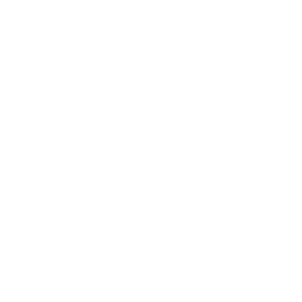

In [100]:
get_all_curve_pattern(deactivate_curved_linkage, min(io.RIBBON_CS), io.SUBDIVISION_RESOLUTION, 'deactivate_ribbon')

In [110]:
len(deactivate_design_parameter)

3560

In [189]:
print(get_segment_index_from_joints(deactivate_curved_linkage, 24, 0))

57


In [150]:
print(get_segment_index_from_joints(deactivate_curved_linkage, 23, 7))

86


In [159]:
deactivate_rl_design_parameter_offset

3382

In [171]:
deactivate_design_parameter[deactivate_rl_design_parameter_offset + 57]

0.3503183062380339

In [162]:
deactivate_design_parameter[deactivate_rl_design_parameter_offset + 0]

0.3492945812922828

In [145]:
len(curved_linkage.getDesignParameters())

3600

In [93]:
curved_linkage.numRestKappaVars()

3420

### End

In [21]:
# save_path = os.getcwd()
# write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = True, width = max(io.RIBBON_CS))
# os.chdir(save_path)

In [103]:
os.chdir(save_path)

In [13]:
export_linkage_geometry_to_obj(curved_linkage, '10mm_width_sphere.obj', scale = 10 / max(io.RIBBON_CS))

In [ ]:
deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(curved_linkage)

In [ ]:
set_joint_vector_field(curved_linkage, curved_linkage_view, joint_normals)

In [ ]:
selected_joints = show_selected_joints(curved_linkage, [60, 83, 49, 84, 89])

In [ ]:
curved_linkage_view.update(vectorField=selected_joints)

## Contact Optimization

In [ ]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

In [ ]:
curved_linkage.setExtendedDoFsPSRL(np.load('results/sphere_1/sphere_1_dof.npy'))

In [ ]:
curved_linkage.attraction_weight = 1e-5

In [ ]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [ ]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = [])

In [ ]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, fixed_boundary_joint = [])

In [ ]:
optimizer.setLinkageAttractionWeight(1e-5)

In [ ]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [ ]:
contact_optimization(optimizer, curved_linkage_view, -1, 1e4)

In [ ]:
structure_view_2 = get_structure_analysis_view(curved_linkage)
structure_view_2.show()